In [35]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from PIL import ImageFile, Image


In [36]:
DATASET_PATH = "MAFood121\\images\\"
METADATA_PATH = "MAFood121\\metadata_win.csv"
IMAGE_PATH_KEY = "image_path"
LABELS_PATH_KEY = "label"
MODEL_PATH = "food-id-red2.h5"
IMAGE_SIZE = 224
BATCH_SIZE = 16
RANDOM_SEED = 115
EPOCHS = 25
TESTING_SIZE = 500
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 239200489

In [37]:
# Loading metadata and splitting into training/validation and testing sets
df = pd.read_csv(METADATA_PATH)

training_and_validation_size = df.shape[0] - TESTING_SIZE

training_df = df[:training_and_validation_size]
testing_df = df[training_and_validation_size:]

training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))
training_df

<ipython-input-37-9f420f2a59a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))


,image_path,label
0,hunkar_begendi\240.jpg,[hunkar_begendi]
1,hunkar_begendi\21.jpg,[hunkar_begendi]
2,naan\49_1.jpg,[naan]
3,ravioli\2725271.jpg,[ravioli]
4,caprese_salad\2358715.jpg,[caprese_salad]
...,...,...
20670,souvlaki\85_2.jpg,[souvlaki]
20671,breakfast_burrito\805523.jpg,[breakfast_burrito]
20672,nachos\500252.jpg,[nachos]
20673,omelette\800743.jpg,[omelette]


In [38]:
# Getting labels
all_labels = [] 

for tags in training_df[LABELS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)
        
unique_labels = list(np.unique(all_labels))

In [39]:
training_data_generator = ImageDataGenerator(rotation_range=30,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode="nearest",
                                             validation_split=VALIDATION_SPLIT,
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=LABELS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 subset="training")

validation_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=LABELS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   subset="validation")


Found 18608 validated image filenames belonging to 121 classes.
Found 2067 validated image filenames belonging to 121 classes.


In [40]:
def model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(BatchNormalization())
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(.5))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(.5))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        #model.add(Dense(256, activation='relu'))
        model.add(Dense(len(unique_labels), activation='sigmoid'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=LEARNING_RATE_DECAY),
                      metrics=["accuracy"])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)


model = model()

In [41]:
# Setting class weights to handle imbalanced data
'''
class_weights = class_weight.compute_class_weight('balanced',
                                                  unique_labels,
                                                  all_labels)

'''
#class_weights = dict(enumerate(class_weights))

"\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                  unique_labels,\n                                                  all_labels)\n\n"

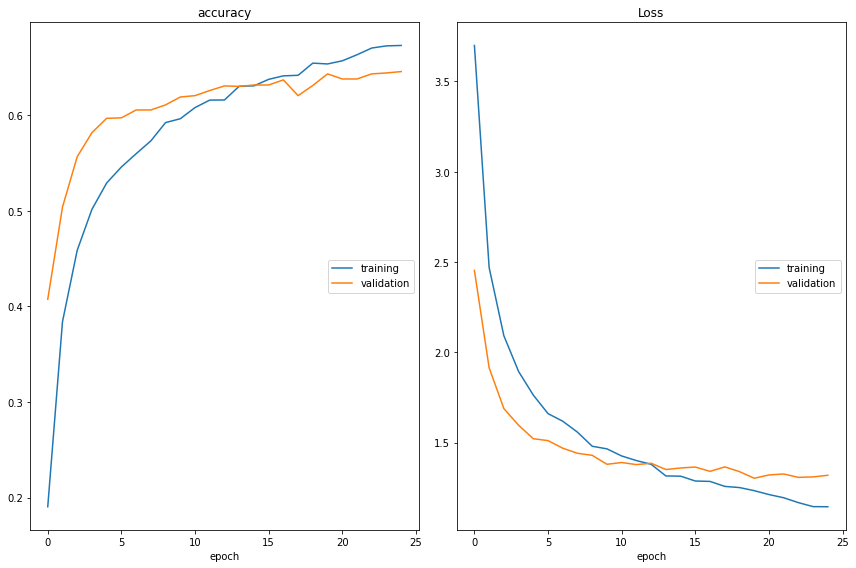

accuracy
	training         	 (min:    0.190, max:    0.673, cur:    0.673)
	validation       	 (min:    0.407, max:    0.646, cur:    0.646)
Loss
	training         	 (min:    1.145, max:    3.699, cur:    1.145)
	validation       	 (min:    1.302, max:    2.454, cur:    1.319)

Epoch 00025: val_accuracy improved from 0.64438 to 0.64583, saving model to food-id-red2.h5


In [42]:
# Training
model.fit_generator(generator=training_generator,
                    #class_weight=class_weights,
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_accuracy',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
model = load_model(MODEL_PATH)

In [43]:
# Testing
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))
predictions = model.predict_generator(testing_generator,
                                      steps=testing_generator.n,
                                      verbose=1)

Found 500 validated image filenames.


c:\users\eric_\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


500/500 [==============================] - 9s 17ms/step


In [44]:
for prediction in predictions:
    print(prediction)

[2.34116360e-05 9.55276264e-05 5.12245751e-04 1.30368835e-06
 7.55513465e-05 1.32688263e-03 4.42108721e-01 3.92583161e-06
 3.87583350e-06 3.72607337e-06 7.07335712e-05 3.87522997e-03
 5.51570156e-05 7.60159921e-04 2.65778112e-03 1.54249521e-03
 1.40605401e-03 3.30579514e-03 1.98981285e-01 2.70124838e-06
 1.69115337e-05 6.00004057e-07 2.80823384e-04 4.36081464e-04
 1.48829877e-05 1.20799575e-06 2.09799633e-04 4.44244915e-06
 3.06535403e-05 2.15757522e-03 4.57858155e-03 2.00274022e-04
 2.82868041e-05 7.68180689e-05 2.94387100e-05 1.73517987e-02
 4.08938422e-06 1.65763868e-05 4.35094256e-03 7.30443187e-03
 5.38993487e-03 1.23636433e-04 1.39829807e-03 5.35310996e-08
 7.88451780e-06 1.32368505e-05 2.67602417e-07 1.25684368e-03
 2.35497669e-06 1.64018693e-05 1.83582433e-05 6.27358077e-06
 9.89456021e-06 6.16503314e-07 1.38253803e-04 2.08365178e-04
 1.60415220e-04 3.60416720e-06 8.64345020e-06 1.04994252e-02
 2.14946067e-05 1.45573635e-04 1.88772301e-05 1.20318757e-04
 1.40364955e-08 3.101972

 2.00093389e-02]
[6.90964371e-05 6.97550831e-07 4.03352635e-04 2.07605865e-03
 6.85507118e-08 2.24680625e-05 8.07618846e-07 1.07595013e-04
 4.40868025e-05 1.67222749e-02 4.65373101e-04 9.15800803e-04
 1.73599201e-05 2.75981594e-02 4.08810729e-06 3.08015359e-07
 2.01966359e-05 5.81571891e-04 3.87830869e-06 9.19807062e-04
 1.31587629e-04 6.11724272e-06 1.78735901e-03 2.85048372e-07
 4.06215804e-06 2.73378822e-03 1.07866708e-05 1.54902472e-03
 1.10290770e-03 3.00105632e-04 8.12049766e-05 5.61316767e-07
 4.68960003e-04 3.56440840e-04 7.82559073e-05 2.53641309e-04
 4.38652234e-04 4.53394096e-05 4.64031837e-05 2.31761042e-05
 2.10390056e-07 2.26872316e-07 2.02618230e-05 1.22910171e-06
 4.86609451e-06 8.69687137e-05 3.22094053e-07 5.84531110e-04
 1.40219381e-05 1.04827241e-05 2.41654678e-04 2.45381889e-05
 2.03384715e-03 4.84837119e-06 9.78974043e-04 2.03071386e-06
 1.79207727e-05 5.47781892e-05 4.00117715e-05 7.15868339e-07
 2.06943555e-03 5.47012947e-02 9.58240616e-06 8.33332717e-01
 1.0192

 1.24784634e-07]
[2.63529409e-06 9.00383515e-04 5.34948413e-07 3.50793927e-09
 7.91629009e-06 1.25422448e-04 8.24138406e-04 2.23757528e-08
 8.93339518e-07 3.25274050e-05 3.67360143e-03 1.56707352e-03
 1.50955628e-07 1.42660268e-04 2.03651609e-04 1.95771481e-05
 6.79062074e-03 1.05701083e-05 8.84213224e-02 3.86629254e-05
 6.90724992e-05 1.27647354e-06 1.02829915e-06 1.03141156e-06
 1.08941265e-06 8.92708977e-06 4.06642823e-04 6.55411895e-07
 8.40350481e-07 1.38761479e-05 6.08413108e-02 3.46313696e-04
 9.21773352e-03 3.86195187e-03 5.17848421e-05 1.74018621e-01
 8.62209054e-05 3.33184494e-06 3.63596555e-05 4.17777710e-03
 1.00341922e-05 1.08005115e-05 1.22594292e-06 9.45786724e-06
 2.11596287e-07 1.79968041e-03 1.20990045e-08 3.27880389e-06
 1.33756248e-05 1.41311546e-07 3.91372567e-04 8.52198127e-07
 1.43931044e-04 3.15110249e-08 2.18717673e-06 2.10726625e-06
 4.38684054e-07 1.55430380e-09 4.56070467e-07 3.26537952e-06
 5.76476858e-04 7.88154488e-04 2.88556366e-05 1.89632920e-04
 4.5291

 1.04806887e-03]
[4.80922833e-02 2.23592383e-06 1.06661825e-03 1.95259883e-04
 5.37002597e-05 2.88864103e-05 2.13616297e-01 3.03532379e-05
 2.47901567e-04 6.58752397e-05 5.33214516e-05 1.95819975e-05
 9.41630715e-05 1.82349856e-06 3.28227109e-03 3.22175473e-02
 4.69067672e-05 4.56864852e-03 9.44842905e-05 7.75077069e-07
 4.64520790e-03 2.04972112e-05 2.69512711e-05 1.30267697e-04
 9.61024985e-02 2.97134818e-07 8.05312266e-06 3.90915484e-05
 6.94758084e-04 1.47794210e-03 2.32449863e-02 9.63427738e-05
 1.61822868e-06 2.22758590e-05 1.32592476e-03 3.96837322e-06
 3.24392454e-06 4.95588058e-04 1.18575139e-04 2.12552259e-04
 6.46072766e-03 6.89046970e-03 2.34597293e-03 4.28733347e-06
 7.50852341e-05 1.52701432e-06 3.27798218e-04 1.87376470e-04
 7.19065952e-07 1.26134137e-05 3.32852187e-06 2.11096267e-04
 9.45329666e-05 1.97335682e-03 1.45818058e-05 2.68045545e-01
 1.83595409e-06 4.80477698e-03 6.79091590e-06 2.41497517e-04
 3.99172450e-06 5.13903558e-07 1.59439824e-05 1.78529137e-06
 7.1392

 7.86063595e-07]
[1.5191117e-05 3.2589039e-06 1.6790765e-06 6.9267588e-07 7.9220910e-05
 6.7496958e-06 7.2269858e-04 1.5034956e-05 1.1746030e-07 1.4740335e-06
 5.5267433e-06 4.9509622e-06 1.0555708e-05 1.7783859e-07 9.8607006e-06
 1.4213588e-04 2.4997894e-06 1.0239581e-05 1.5714269e-07 1.2134016e-07
 1.1607482e-05 4.3691733e-05 1.5958796e-05 5.3157705e-01 1.1253721e-04
 1.5267497e-07 1.6167683e-05 1.1984990e-07 1.5365451e-07 1.4019546e-05
 3.7595903e-05 1.9722340e-06 1.8407979e-06 7.3769144e-07 1.3949662e-07
 4.3058823e-04 2.2517982e-07 7.5590805e-07 8.5523334e-06 2.2500637e-07
 5.1557004e-07 3.8004425e-06 3.3893588e-07 1.1206067e-07 7.7659293e-05
 7.7263594e-06 3.2209550e-06 4.9308202e-09 8.3587730e-07 1.5444306e-06
 7.8003248e-09 2.4337448e-06 7.5640634e-07 3.2365064e-05 3.3901510e-05
 4.8553961e-06 4.8030365e-06 4.9436608e-07 1.3078483e-06 1.4709793e-04
 4.8184819e-07 5.2503452e-08 5.7612178e-05 2.4219107e-08 2.2222141e-06
 2.4080820e-05 9.2634210e-08 8.7117606e-08 3.3284181e-07 3.1

 5.5418748e-02]
[4.58031327e-01 1.62201744e-07 3.81682810e-11 1.25978703e-08
 4.55731742e-06 8.02030442e-09 6.09229319e-05 9.09050080e-09
 2.40101572e-02 1.63143113e-07 1.17772959e-06 2.92885804e-08
 1.31475110e-06 1.27876447e-08 6.54343850e-08 5.08798337e-08
 2.68550889e-06 4.70958457e-06 8.44354986e-08 5.13635401e-09
 3.93948802e-08 4.94862206e-07 1.17160744e-06 4.38228176e-10
 9.06940386e-06 6.61875265e-06 5.27792032e-10 9.33736910e-09
 3.77242640e-03 5.68465808e-08 3.81911150e-07 2.53815013e-08
 3.81927912e-09 2.42454425e-05 8.93344954e-09 2.69349215e-07
 4.23804204e-06 1.69570002e-09 1.50967495e-07 2.15428427e-05
 8.21222290e-09 1.18364114e-04 4.16547759e-04 2.05094537e-08
 3.56080321e-08 4.65793789e-07 1.05421144e-07 1.28685861e-04
 1.57228806e-06 1.18001857e-08 2.53891187e-07 9.75952389e-07
 4.75620800e-05 2.00842733e-05 6.94432174e-08 8.32772912e-06
 2.27483499e-09 1.77559207e-06 2.11190017e-08 1.16224840e-06
 1.27594888e-07 7.04514065e-08 1.11429292e-08 5.50014185e-08
 5.57839

 1.35407943e-04]
[1.43481293e-06 2.36665801e-06 2.22537186e-04 8.48249258e-08
 2.04434696e-06 3.12605145e-04 7.47219077e-04 7.19028392e-08
 5.80118649e-06 3.55045771e-08 3.68063374e-05 6.04078581e-04
 2.22771366e-08 3.98095144e-05 3.69697111e-03 3.45748526e-06
 5.04061463e-04 4.89900813e-05 4.58443992e-06 3.29457616e-05
 1.00819125e-04 5.93664197e-07 3.78653931e-06 2.83189502e-06
 5.54469182e-08 7.36278025e-07 2.10480775e-05 8.79377581e-07
 3.34370657e-06 9.66479448e-08 5.09894699e-06 2.04608295e-06
 2.14152783e-06 1.02998711e-05 2.67504685e-04 1.13335394e-04
 3.33820566e-07 1.95948178e-06 2.75573399e-07 9.04819026e-05
 9.78711426e-01 5.98725164e-03 7.13902846e-05 5.45172479e-05
 4.46081685e-06 2.49535651e-06 3.48235680e-08 3.82651458e-04
 2.26279099e-06 2.15739492e-05 2.55941795e-05 2.70062706e-09
 6.32327835e-09 4.86161795e-08 1.90020194e-06 8.31424245e-07
 4.48660539e-05 5.39111120e-08 5.76148871e-08 6.18302101e-06
 3.92455462e-07 2.59934473e-06 3.58331774e-04 1.00680045e-05
 2.3679

 1.06689599e-08]
[1.1403231e-11 8.4379067e-08 4.2573922e-10 1.8036228e-09 2.6955933e-13
 2.7931313e-10 1.7327538e-10 3.4538900e-13 8.3427303e-13 2.0547743e-10
 3.2159710e-07 1.8992415e-08 4.0537184e-13 2.0732376e-10 4.7180308e-08
 2.6225783e-10 4.0956433e-11 2.0761275e-09 4.2191646e-06 9.9176418e-08
 1.5137660e-11 2.9710858e-13 4.0409021e-10 6.6142451e-14 1.4591215e-11
 1.9578477e-09 7.4924606e-07 3.5936040e-08 1.6881170e-10 1.6357984e-10
 2.5480254e-10 3.1705724e-14 3.3717424e-07 4.5100762e-10 1.9928304e-08
 4.2251113e-08 1.0600267e-08 1.7064522e-11 7.0818662e-10 1.0126756e-08
 3.4064349e-11 6.6285893e-11 2.3093185e-11 1.7467622e-08 5.4186655e-12
 2.0747112e-08 2.2585677e-13 9.3446939e-10 5.1169841e-10 4.3258426e-12
 4.6638533e-09 2.5870514e-13 3.0082421e-09 4.3671092e-13 4.5448618e-09
 2.6344689e-11 2.0472075e-11 1.6394106e-12 4.2346754e-10 6.8151049e-12
 5.1444076e-09 4.4944539e-07 1.7348201e-07 6.4994878e-11 5.2689220e-14
 6.1177230e-11 1.3451741e-09 5.2774272e-08 3.4409480e-14 4.7

 3.72466375e-03]
[3.16134475e-07 1.22935012e-06 1.38612211e-01 1.48438573e-01
 1.06347660e-08 2.66472431e-04 1.07976062e-04 3.31919982e-05
 4.76691275e-06 1.46940852e-06 1.91730924e-03 1.23014252e-04
 1.96819397e-04 3.26788373e-04 1.29148439e-02 1.60439685e-01
 5.11643630e-05 1.24892581e-03 4.20595752e-05 6.40004594e-03
 4.70324792e-03 1.34412073e-06 1.23581458e-07 1.65819483e-06
 1.89064210e-07 7.65199459e-08 4.43790620e-03 1.02275021e-01
 1.05104427e-05 6.34630793e-04 2.70337769e-04 5.58307306e-07
 6.71927410e-04 2.68037220e-05 1.49348965e-02 3.84422638e-05
 1.22475527e-07 4.58443083e-06 1.22400627e-06 2.52272599e-07
 2.46487744e-03 5.51554561e-03 1.00453828e-04 5.90457921e-06
 6.14434853e-03 1.06010622e-04 3.12432633e-07 3.85549029e-05
 7.77637368e-08 5.97795937e-04 2.41242480e-04 2.52291588e-09
 1.08366869e-07 6.17069329e-09 9.26182395e-07 1.33986521e-06
 1.20539195e-03 9.07602100e-08 5.50157608e-07 4.62319854e-08
 2.07595053e-06 6.51197809e-07 3.36039026e-04 2.15838663e-05
 4.6065

 4.24446916e-04]
[1.23966774e-05 1.09612658e-04 3.39518670e-06 8.29196409e-08
 1.94943241e-05 2.28402321e-03 8.26647319e-03 2.18951701e-08
 4.42226701e-06 1.09936821e-07 1.05189636e-01 6.38891160e-02
 2.80081294e-05 9.42202223e-06 2.08655698e-03 1.81218213e-03
 2.51952000e-02 6.39254067e-05 9.42079350e-03 1.52066129e-03
 9.28755268e-04 2.50537050e-05 7.01955605e-06 2.22687395e-05
 1.49711887e-08 3.00167740e-04 2.37431290e-04 4.28619387e-05
 6.24788809e-05 2.30865975e-04 4.09561396e-03 2.51665071e-04
 2.56017735e-03 1.44596852e-03 8.19648194e-05 9.39107314e-03
 3.34911136e-04 6.24185894e-03 1.51855624e-04 1.87478717e-02
 9.44258994e-04 3.49628069e-02 2.03125455e-04 3.39161430e-04
 5.39936445e-06 6.73194299e-05 8.52998880e-08 5.76993800e-04
 1.03523314e-03 1.48221734e-03 1.27731869e-02 4.24602604e-07
 4.09409964e-08 1.23773731e-07 2.14297343e-05 4.39401447e-07
 1.81309995e-04 3.61918282e-08 9.66922016e-06 1.37785983e-05
 1.93457818e-04 6.25909190e-04 2.38776603e-03 8.13027327e-06
 9.9896

 6.48314597e-07]
[6.46281393e-08 8.43813837e-08 1.43011869e-06 2.38806588e-05
 3.84570287e-09 2.34445506e-05 5.03200181e-06 5.02511952e-08
 1.99113659e-09 4.30977764e-07 1.71433646e-06 1.42030535e-06
 2.21111281e-06 4.44935218e-08 3.73114108e-06 6.74254901e-04
 3.63406258e-07 1.78388545e-05 1.05141899e-05 1.70220176e-07
 6.90912520e-06 1.52440227e-09 3.91930399e-08 1.11449324e-03
 1.34146532e-07 1.62909697e-09 6.28535508e-06 1.04254612e-03
 1.61574590e-07 1.89242619e-05 9.73778469e-07 2.14060432e-08
 7.40468977e-07 1.92855111e-07 9.83844875e-05 2.69227030e-06
 2.88470248e-09 6.74399871e-06 3.02920889e-05 9.77247623e-07
 1.26089217e-05 4.45298610e-06 2.20042875e-06 3.58180108e-09
 7.96313060e-08 1.91507482e-07 1.08031033e-08 7.27447741e-06
 9.61033493e-08 5.08214180e-05 1.24148229e-07 2.77124568e-09
 1.26495209e-07 3.63593777e-09 3.84325567e-08 1.19223898e-07
 1.17669103e-03 2.71721596e-08 1.26526103e-07 1.25330914e-07
 1.26461558e-07 2.73414997e-07 5.44856277e-07 1.26429953e-07
 5.0136